### 5'UTR Annotation data analysis

This code computes some summary statistics for 5'UTR data

In [2]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle
import itertools
import functools
import operator

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats
import ahocorasick

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib_config
import seaborn as sns
from plotnine import *

import keras
from keras import backend as K
from keras import losses
from keras.models import load_model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

Using TensorFlow backend.


In [3]:
reload(matplotlib_config)
matplotlib_config.paper_config()

#### Read in the data

In [4]:
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)
    
seq_df = pd.read_csv("../Data/gencodev19_5utr_seq.csv")

data_df = data_dict["mpra"]
snv_df = data_dict["snv"]
ptr_df = data_dict["ptr"]
doudna_df = data_dict["doudna"]
varlen_df = data_dict["varlen_mpra"]

In [5]:
mpra_df = data_df[data_df["library"] == "egfp_unmod_1"]

### Human UTR distribution

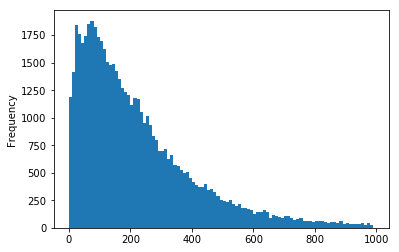

In [12]:
seq_df["utr"].str.len().plot.hist(bins=np.arange(0,1000,10))

In [76]:
(np.sum((seq_df["utr"].str.len() <= 200) & (seq_df["utr"].str.len() > 0))/len(seq_df["utr"]))*100

55.489319423745656

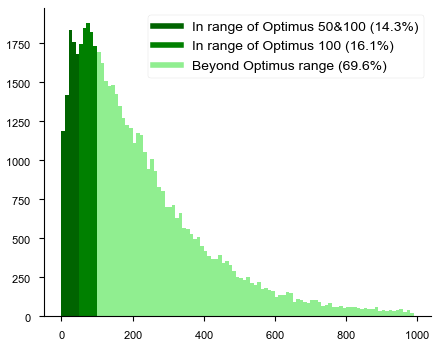

In [64]:
colors = ["darkgreen", "green", "lightgreen"]
font_size=10
fig_dims = (5.0, 4.0)

fig, ax = plt.subplots()
N, bins, patches = ax.hist(seq_df["utr"].str.len(), bins=np.arange(0,1000,10), color=colors[2])

for i in range(0,5):
    patches[i].set_facecolor(colors[0])
for i in range(5,10):    
    patches[i].set_facecolor(colors[1])

optimus50_pct = (np.sum(seq_df["utr"].str.len() <= 50)/len(seq_df["utr"]))*100
optimus100_pct = (np.sum((seq_df["utr"].str.len() <= 100) & (seq_df["utr"].str.len() > 50))/len(seq_df["utr"]))*100
beyond_pct = (np.sum(seq_df["utr"].str.len() > 100)/len(seq_df["utr"]))*100
    
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]
ax.legend(custom_lines, ["In range of Optimus 50&100 (" + str(round(optimus50_pct,1)) + "%)",
                         "In range of Optimus 100 (" + str(round(optimus100_pct,1)) + "%)",
                         "Beyond Optimus range (" + str(round(beyond_pct,1)) + "%)"],
         fontsize=font_size)
sns.despine(fig)
fig.set_size_inches(fig_dims)
fig.savefig("../Graphics/utrlen_hist.svg")

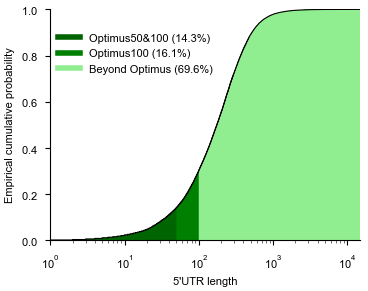

In [80]:
import statsmodels.api as sm

font_size=8
fig_dims = (4.0, 3.0)

colors = ["darkgreen", "green", "lightgreen"]

sample = np.array(seq_df["utr"].str.len())
ecdf = sm.distributions.ECDF(sample)

fig, ax = plt.subplots()
x = np.sort(sample)
y = ecdf(x)
ax.step(x, y, where="post", c="black")
idx1 = np.argmax(x >= 50)
idx2 = np.argmax(x >= 100)
ax.fill_between(x[0:], 0, y[0:], facecolor=colors[0], step="post")
ax.fill_between(x[idx1:], 0, y[idx1:], facecolor=colors[1], step="post")
ax.fill_between(x[idx2:], 0, y[idx2:], facecolor=colors[2], step="post")
ax.set_ylim(0,1.0)
ax.set_xlim(1,max(sample))
ax.set_ylabel('Empirical cumulative probability', fontsize=font_size)
#ax.set_xticks(x_pos)
#ax.set_xticklabels(names)
ax.set_xlabel("5'UTR length", fontsize=font_size)
#ax.vlines(50, ymin=0, ymax=1)
#ax.vlines(100, ymin=0, ymax=1)
ax.set_xscale('log')

optimus50_pct = (np.sum(seq_df["utr"].str.len() <= 50)/len(seq_df["utr"]))*100
optimus100_pct = (np.sum((seq_df["utr"].str.len() <= 100) & (seq_df["utr"].str.len() > 50))/len(seq_df["utr"]))*100
beyond_pct = (np.sum(seq_df["utr"].str.len() > 100)/len(seq_df["utr"]))*100
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]
ax.legend(custom_lines, ["Optimus50&100 (" + str(round(optimus50_pct,1)) + "%)",
                         "Optimus100 (" + str(round(optimus100_pct,1)) + "%)",
                         "Beyond Optimus (" + str(round(beyond_pct,1)) + "%)"],
          frameon=False,
          loc=(0.01,0.70),
         fontsize=font_size)

sns.despine(fig)
fig.set_size_inches(fig_dims)
fig.savefig("../Graphics/utrlen_ecdf.svg")

### Variable length MPRA

In [5]:
hits = varlen_df["utr"].str.rfind("ATG")
hit_df = varlen_df.copy()
hit_df["hits"] = hits
hit_df = hit_df[hit_df["hits"] > -1]
hit_df["dist"] = hit_df["len"] - hit_df["hits"]
hit_df["hit_bins"] = pd.cut(hit_df["len"] - hit_df["hits"], np.arange(0, 100, 1))
hit_df["frame"] = (hit_df["len"] - hit_df["hits"]) %3

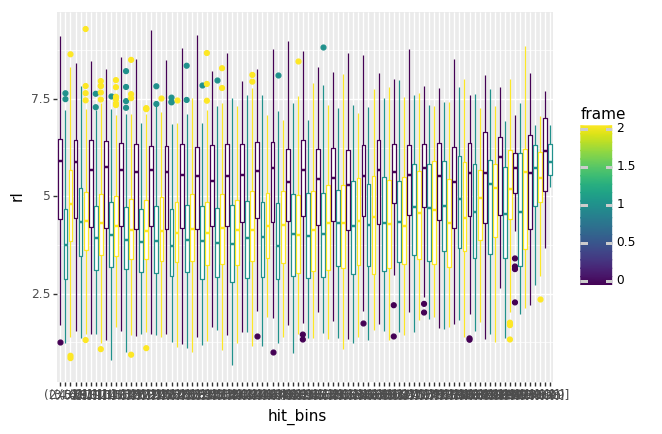

<ggplot: (-9223363284089607024)>

In [6]:
(ggplot(aes(x="hit_bins", y="rl"), data=hit_df) + 
 geom_boxplot(aes(color="frame")))

In [7]:
hit_df_1aug = hit_df[hit_df.utr.str.count("ATG") == 1]

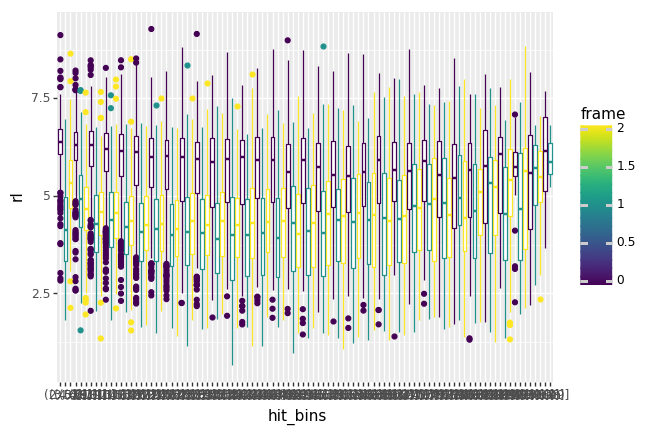

<ggplot: (8752764380813)>

In [8]:
(ggplot(aes(x="hit_bins", y="rl"), data=hit_df_1aug) + 
 geom_boxplot(aes(color="frame")))

In [ ]:
hits = varlen_df["utr"].str.find("ATG")
hit_df_left = varlen_df.copy()
hit_df_left["hits"] = hits
hit_df_left = hit_df_left[hit_df_left["hits"] > -1]
hit_df_left["dist"] = hit_df_left["len"] - hit_df_left["hits"]
hit_df_left["hit_bins"] = pd.cut(hit_df_left["len"] - hit_df_left["hits"], np.arange(0, 100, 1))
hit_df_left["frame"] = (hit_df_left["len"] - hit_df_left["hits"]) %3